In [1]:
import numpy as np
import qutip as qt
from scipy.linalg import expm
import matplotlib.pyplot as plt
np.set_printoptions(suppress=False)
import time
from joblib import Memory
from joblib import Parallel, delayed
%matplotlib inline
import scipy.integrate as integrate
import pickle

In [3]:
class simulation_two_dots():
    """Initialize two dot simulation object
    
    Args:
        B1 (double): Zeeman energy of dot 1
        B2 (double): Zeeman energy of dot 2
        tunnel_coupling (double): tunnel coupling between the dots
        U1 (double): Charge energy of dot 1
        U2 (dobule): Charge energy of dot 2
    """
    def __init__(self, B1,B2,tunnel_coupling,U1,U2):
        '''Initializes the two electron spin hamiltonian. The energies are in units of Hz.

        Args:
            B1 (double): Zeeman energy of dot 1
            B2 (double): Zeeman energy of dot 2
            t (double): Tunnel coupling
            U1 (double): Coulomb energy dot 1
            U2 (double): Coulomb energy dot 2


        '''
        self.tunnel_coupling = tunnel_coupling
        self.B1 = B1
        self.B2 = B2
        self.U1 = U1
        self.U2 = U2
        self.freq_q1 = B1
        self.freq_q2 = B2
        h = np.zeros((6,6),dtype=complex)
        h[0,0]=-(B1+B2)/2
        h[1,1]=-(B1-B2)/2;h[1,4:6]=tunnel_coupling
        h[2,2]=(B1-B2)/2;h[2,4:6]=-tunnel_coupling
        h[3,3]=(B1+B2)/2
        h[4,1]=tunnel_coupling;h[4,2]=-tunnel_coupling;h[4,4] = U1
        h[5,1]=tunnel_coupling;h[5,2]=-tunnel_coupling;h[5,5]=U2
        self.hamiltonian = 2*np.pi*h
        self.H_charge = np.zeros((6,6),dtype=complex);self.H_charge[4,4] = self.U1;self.H_charge[5,5] = self.U2;
        self.H_charge=self.H_charge*2*np.pi
        self.tunnel_params = [] #Will contain all tunnel pulses, each element characterizing the tunnel pulse through parameters
        self.magnetic_params = [] ##Will contain all magnetic pulses, each element characterizing the magnetic pulse through parameters
        self.Htotal = 0
        self.detuning_params= [] ##Will contain all detuning pulses, each element characterizing the detuning pulse through parameters
        self.zz = np.diag(np.ones(6));self.zz[4,4]=0;self.zz[5,5]=0
    #Ht1 and Ht2 are the Hamiltonians corresponding to the tunnel coupling and 
    #conjugate of the tunneling coupling terms respectively
    Ht2=np.zeros((6,6),dtype=complex);Ht2[4,1]=1;Ht2[5,1]=1;Ht2[2,4]=-1;Ht2[2,5]=-1;
    Ht1=np.zeros((6,6),dtype=complex);Ht1[4,2]=-1;Ht1[5,2]=-1;Ht1[1,5]=1;Ht1[1,4]=1;
    #Magnetic field hamiltonians corresponding to the magnetic field terms and their conjugates (mw = microwave)
    Hmw_q2 = np.zeros((6,6),dtype=complex);Hmw_q2[0,1]=1;Hmw_q2[2,3]=1;
    Hmw_q1 = np.zeros((6,6),dtype=complex);Hmw_q1[0,2]=1;Hmw_q1[1,3]=1;
    Hmw_q2_conjugate = np.zeros((6,6),dtype=complex);Hmw_q2_conjugate[1,0]=1;Hmw_q2_conjugate[3,2]=1;
    Hmw_q1_conjugate = np.zeros((6,6),dtype=complex);Hmw_q1_conjugate[2,0]=1;Hmw_q1_conjugate[3,1]=1;

    
    

    def add_tunnel_pulse(self,t_ampl,t_start,t_end):
        """Adds the parameters of a tunneling pulse to the list containing all the tunnel pulse parameters

        Args:
            t_ampl (int or double): tunneling amplitude
            t_start and t_end (int or double): start time and end time of the pulse
        """
        self.tunnel_params.append([t_ampl,t_start,t_end])
    def add_magnetic_pulse(self, rabi_freq, phase, drive_freq, t_start, t_end):
        """Adds the parameters of a magnetic pulse to the list containing all the tunnel pulse parameters

        Args:
            rabi_freq (double): Amplitude of the pulse
            phase (double): Phase of the pulse
            drive_freq (double): Frequency of the pulse
            t_start (double): Start time of the pulse
            t_end (double): End time of the pulse
        """        
        self.magnetic_params.append([rabi_freq,phase,drive_freq,t_start,t_end])
    
    def add_detuning_pulse(self,detuning_energy,t_start,t_end):
        """Adds the parameters of a detuning pulse to the list containing all the tunnel pulse parameters

        Args:
            detuning_energy: Energy of the detuning
            t_start (double): Start time of the pulse
            t_end (double): End time of the pulse
        """           
        self.detuning_params.append([detuning_energy, t_start, t_end])
    
    def tunnel_coeff(self,tunnel_ampl,t):
        return 2*np.pi*tunnel_ampl*np.exp(1j*2*np.pi*(self.B1-self.B2)/2*t)
    def mw_coeff(self,params,dw,t,q):
        #rabi_freq = params[0]
        #phase = params[1]
        #drive_freq = params[2]
        

        return np.exp(1j*2*np.pi*(dw)*t)

    def integrate(self,t0,td):
        N=10 #number of elements to sum in the Riemann sum
        dt = (td-t0)/N 
        t_ax = np.linspace(t0,td,N+1) #create time axis for the Riemann sum
        t_ax = (t_ax[:-1]+t_ax[1:])/2 #use the midpoint Riemann sum
        #t_ax = t_ax[1:]
        Ht_tun = np.zeros((6,6),dtype=complex) #Will contain the result of the Riemann sum for all tunneling terms
        Ht_mag = np.zeros((6,6),dtype=complex) #Will contain the result of the Riemann sum for all magnetic terms
        Ht_det = np.zeros((6,6),dtype=complex) #Will contain the result of the Riemann sum for all detuning terms
        for i, params in enumerate(self.tunnel_params): #Calculates the Riemann sum for every tunnel pulse
            tunnel_ampl = params[0]
            time_interval = ((t_ax<=params[2])&(t_ax>=params[1])) 
            if time_interval.any():
                t = t_ax[time_interval] #tunnel coefficient is non zero between t_start and t_end, so only calculate those terms
                tunnel_coeff1 = -np.sum(self.tunnel_coeff(tunnel_ampl,t)*dt)
                tunnel_conjugate= -np.conj(tunnel_coeff1)
                #add the result of the Riemann for every tunnel pulse to the total integral
                Ht_tun += tunnel_coeff1*self.Ht1+tunnel_conjugate*self.Ht2 
                #Ht_tun += np.trapz(self.tunnel_coeff(tunnel_ampl,t),dx = dt)
        for i, params in enumerate(self.magnetic_params):
            #rabi_freq = params[0]
            #phase = params[1]
            #drive_freq = params[2]
            t_start = params[3]
            t_end = params[4]
            time_interval = ((t_ax<=t_end)&(t_ax>=t_start))
            if time_interval.any():
                t = t_ax[time_interval]
                #(mw_q1_coeff) is the magnetic pulse term for qubit 1, mw_q1_coeff_conjugate is its conjugate
                
                dw_q1 = params[2]-self.freq_q1
                dw_q2 = params[2]-self.freq_q2
                #dw_q1 = np.random.normal(dw_q1,2e3)
                #dw_q2 = np.random.normal(dw_q2,2e3)
                bmw = params[0]#np.random.normal(params[0],2e6)
                mw_q1_coeff = 0.5*2*np.pi*bmw*np.exp(1j*params[1])*np.sum(self.mw_coeff(params,dw_q1,t,'q1')*dt)

                mw_q1_coeff_conjugate = np.conj(mw_q1_coeff)

                mw_q2_coeff = 0.5*2*np.pi*bmw*np.exp(1j*params[1])*np.sum(self.mw_coeff(params,dw_q2,t,'q2')*dt)

                mw_q2_coeff_conjugate = np.conj(mw_q2_coeff)

                #Calculate the result of the Riemann sum and add it to the total integral 
                Ht_mag += mw_q1_coeff*self.Hmw_q1+mw_q1_coeff_conjugate*self.Hmw_q1_conjugate+\
                mw_q2_coeff*self.Hmw_q2+mw_q2_coeff_conjugate*self.Hmw_q2_conjugate

        for i, params in enumerate(self.detuning_params):
            epsilon = params[0]
            t_start = params[1]
            t_end = params[2]
            time_interval = ((t_ax<=t_end)&(t_ax>=t_start))
            if time_interval.any():
                t = t_ax[time_interval]

                detuning1_coeff = -np.sum(2*np.pi*epsilon*dt*time_interval)
                #detuning2_coeff = -detuning1_coeff
                H_detuning1 = qt.basis(6,4)*qt.basis(6,4).dag().full()
                H_detuning2 = qt.basis(6,5)*qt.basis(6,5).dag().full()
                H_detuning = detuning1_coeff*H_detuning1-detuning1_coeff*H_detuning2
                Ht_det += H_detuning
            #print(td,t0,self.H_charge*(td-t0))
        #r = 0.011
        #s1=np.random.normal(0,r)
        #s2=np.random.normal(0,r)
        return self.H_charge*(td-t0)+Ht_tun+Ht_mag+Ht_det

    def multiply(self,U,rho):
        return U@rho@np.conj(U.T)
    def evolve(self,n,t_start,t_end,nsteps,nsamples):
        """Evolve the system in time
        
        Args:
            n (int): state to evolve
            t_start and t_end (double): evolve between times t_start and t_end
        
        Returns:
            (list of numpy arrays): First element is the unitary operator U that generates the evolution of the state.
                    Second element are the density operators of the state as a function of time.
                    Third element is the coefficient |c_n(t)|^2 as a function of time belonging the the state n
        """
        
        tlist = np.linspace(t_start,t_end,nsteps+1) #Evolve for this time axis
        psi0=np.array(qt.basis(6,n)*qt.basis(6,n).dag().full(),dtype=complex) #The state to evolve in Heisenberg picture
        rhos = [psi0] #The state as a function of time
        U_t = np.zeros((nsteps,6,6),dtype=complex) # The evolution operator as a function of time

        #Add tunnel parameters when tunneling is non zero
        if self.tunnel_coupling!= 0:
            self.add_tunnel_pulse(self.tunnel_coupling,t_start,t_end)   
        #Perform the time evolution of the state n
        M = []
        M.append(psi0)
        
        """ 
        start = time.time()
        U_pl = [expm(1j*self.integrate(tlist[i],tlist[i+1]))\
                for i in range(len(tlist)-1)]
        stop = time.time()
        
        print('Elapsed time for the entire processing: {:.2f} s'
              .format(stop - start))
        """
        #Integrals = Parallel(n_jobs=2)(delayed(self.integrate)(tlist[i],tlist[i+1]) for i in range(len(tlist)-1))
        
        start = time.time()

        

        
        U_pl_n_samples = Parallel(n_jobs=8,backend = 'loky')(delayed(expm)(1j*self.integrate(tlist[i],tlist[i+1]))
                                    for i in range(len(tlist)-1) for j in range(nsamples))
        
        stop = time.time()
        
        print('Elapsed time for the unitary evolution operator: {:.2f} s'
              .format(stop - start))
        
        U_pl = [np.sum(U_pl_n_samples[i*nsamples:(i+1)*nsamples],axis=0)/nsamples for i in range(nsteps)]
        rhos_pl = [M.append(self.multiply(U_pl[i],M[i])) for i in range(len(tlist)-1)]
        
        psi0_t = np.trace(np.real(np.array(M))@(qt.basis(6,n)*qt.basis(6,n).dag()).full(),axis1=1,axis2=2,dtype=complex)

        self.plot_probabilities([0,1,2,3,4,5],tlist, M)

        return U_pl, np.array(rhos_pl),psi0_t, U_pl_n_samples
        
    def plot_probabilities(self,states,tlist,rhos):
        stat = [r'$|\downarrow\downarrow\rangle$',r'$|\downarrow\uparrow\rangle$',r'$|\uparrow\downarrow\rangle$',
        r'$|\uparrow\uparrow\rangle$', 'S(2,0)','S(0,2)']
        p = []
        p0=[]
        c = ['royalblue','orange','mediumseagreen','crimson']
        plt.figure()
        for i in states:
            p.append(np.trace(np.array(rhos)@(qt.basis(6,i)*qt.basis(6,i).dag()).full(),axis1=1,axis2=2,dtype=complex))
        for i, prob in enumerate(p):
            plt.plot(tlist*1e9,np.real(prob),label=stat[states[i]])

        plt.xlabel("t (ns)")
        plt.ylabel('probability')
        plt.legend(loc='best',bbox_to_anchor=(1,1), fontsize = 'x-large')
        plt.show() 
        



Elapsed time for the unitary evolution operator: 1.48 s


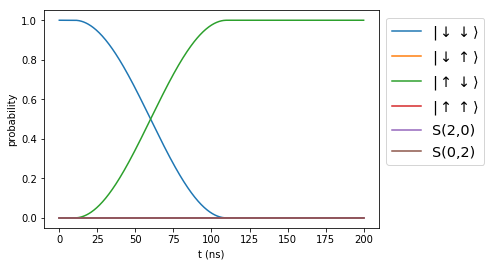

1.932419776916504  s


In [4]:
#Single qubit rotation

#Create a simulation object
s = simulation_two_dots(B1=1e9,B2=2e9,tunnel_coupling=0,U1=2e12,U2=2.1e12) #B1, B2, tunnel_ampl, U1, U2

#Add a magnetic pulse with a driving frequency equal to the Zeeman energy of one of the dots,
#for a time such that it rotates pi radians
s.add_magnetic_pulse(0.5e7,0,1e9,10e-9,110e-9)#Rabi_freq, phase, drive_freq, t_start, t_end

time1=time.time()
#Evolve the state 0 for a certain time range
#state to elove,, t_start, t_end, nsteps,nsamples
d=s.evolve(0,0,200e-9,1000,nsamples=1)

print(np.around(time.time()-time1,20), " s")


Elapsed time for the unitary evolution operator: 10.59 s


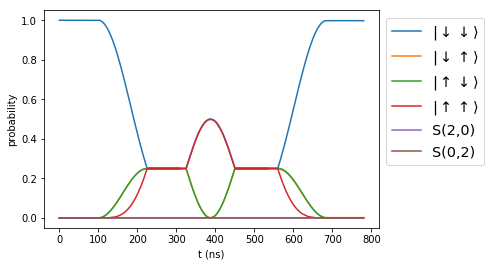

10.91  s


In [5]:

phase_q1 = np.pi/2
phase_q2 = np.pi/2

detE = 828.6e9
a = 35e-9
#create a two dot simulation object
grover = simulation_two_dots(19.7e9,18.4e9,0.250e9,850e9,840e9)

#Add magnetic pulses that rotate both qubits pi/2 radians
#to create an equal superposition
grover.add_magnetic_pulse(2e6,np.pi/2,18.4e9,100e-9,225e-9)
grover.add_magnetic_pulse(2e6,np.pi/2,19.7e9,100e-9,225e-9)

#Add detuning pulse to apply the CZ gate (the oracle of the grover algorithm)
grover.add_detuning_pulse(detE,225e-9,275e-9+a)

#Create Bell state and equal superposition with marked state
grover.add_magnetic_pulse(2e6,np.pi/2+phase_q1,19.7e9,325e-9,450e-9)
grover.add_magnetic_pulse(2e6,np.pi/2+phase_q2,18.4e9,325e-9,450e-9)

grover.add_detuning_pulse(detE,451e-9,501e-9+a)

#Required for readout, "undo" the superposition
grover.add_magnetic_pulse(2e6,np.pi+phase_q1,19.7e9,560e-9,685e-9)
grover.add_magnetic_pulse(2e6,np.pi+phase_q2,18.4e9,560e-9,685e-9)

time0 = time.time()
#Evolve the system
psi0=0
U_t,rhos,psi0_t,sampl = grover.evolve(psi0,0,780e-9,nsteps=3000,nsamples=1)
print(np.around(time.time()-time0,2), " s")

Elapsed time for the unitary evolution operator: 0.27 s


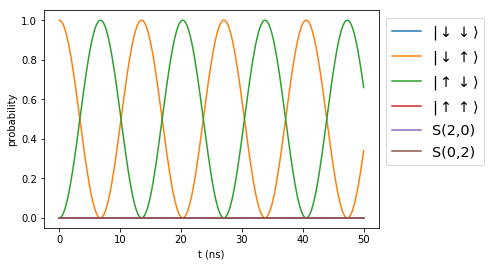

0.48  s


In [6]:
psi0 = 0
phase_q1 = np.pi/2
phase_q2 = np.pi/2

a = 35e-9
#create a two dot simulation object
grover = simulation_two_dots(2e9,2e9,0*0.250e9,1e12,1e12)
grover.add_tunnel_pulse(4.3e9,0,50e-9)
#Add magnetic pulses that rotate both qubits pi radians
#grover.add_magnetic_pulse(2e6,np.pi/2,18.4e9,100e-9,225e-9)
#grover.add_magnetic_pulse(2e6,np.pi/2,19.7e9,100e-9,225e-9)

#Add detuning pulse to obtain the CZ gate (the oracle of the grover algorithm)
#grover.add_detuning_pulse(828.6e9,225e-9,275e-9+a)

#This part is required for the grover diffusion 
#grover.add_magnetic_pulse(2e6,np.pi/2+phase_q1,19.7e9,325e-9,450e-9)
#grover.add_magnetic_pulse(2e6,np.pi/2+phase_q2,18.4e9,325e-9,450e-9)

#grover.add_detuning_pulse(828.6e9,451e-9,501e-9+a)

#Required for readout, "undo" the superposition

#grover.add_magnetic_pulse(2e6,np.pi+phase_q1,19.7e9,560e-9,685e-9)

#grover.add_magnetic_pulse(2e6,np.pi+phase_q2,18.4e9,560e-9,685e-9)

time0 = time.time()
#Evolve the system
U_t,rhos,psi0_t,U_samples = grover.evolve(1,0,50e-9,1000,1)
print(np.around(time.time()-time0,2), " s")